In [ ]:
# DBSCAN clustering 
import numpy as np
from sklearn.cluster import  DBSCAN
from sklearn.metrics import confusion_matrix, f1_score, normalized_mutual_info_score, precision_score, recall_score
import pandas as pd
import timeit
import matplotlib.pyplot as plt
import os 

In [ ]:
# the method specifies key to make sure the ground truth set is in consistent order as the valeus accessed 
def ground_truth_set(key):
    ground_truth = []
    for item in key:
        if "Palm" in item: 
            ground_truth.append(1)
        else:
            ground_truth.append(0)
    
    return np.array(ground_truth)

def data_set(key, dict):
    data = []
    for item in key:
        data.append(dict[item])
    return np.array(data)

def get_truth_and_data(fileName):
    dict = np.load(fileName, allow_pickle=True).item()
    dict_keys = dict.keys()
    ground_truth = ground_truth_set(dict_keys)
    data_values = data_set(dict_keys, dict)

    return ground_truth, data_values

def accuracy(truth, pred):
    tn, fp, fn, tp = confusion_matrix(truth, pred, labels=[0,1]).ravel()
    return (tn+tp)/ (tn+ fp+ fn+ tp)

def three_d_accuracy(truth, pred):
    matrix1 = confusion_matrix(truth, pred, labels=[-1,0,1])
    
    trues1 = matrix1[0][0]+matrix1[1][1]+matrix1[2][2]
    accuracy_percent1 = trues1/len(truth)

    #see if swapped around is better 
    mapping = {-1:-1, 0: 1, 1: 0}
    # Reassign the labels using the mapping
    new_pred = np.array([mapping[label] for label in pred])

    matrix2 = confusion_matrix(truth, new_pred, labels=[-1,0,1])
    
    trues2 = matrix2[0][0]+matrix2[1][1]+matrix2[2][2]
    accuracy_percent2 = trues2/len(truth)

    if (accuracy_percent1 > accuracy_percent2):
        print(matrix1)
        # print("1. ", accuracy_percent1)
        return accuracy_percent1
    # print("2. ", accuracy_percent2)
    print(matrix2)
    return accuracy_percent2


In [ ]:
# 2669 trees  
glcm_truth_test_n , glcm_data_test_n  =  get_truth_and_data('GLCM_testN.npy')
glcm_truth_test , glcm_data_test  =  get_truth_and_data('GLCM_test.npy')

hist_truth_n_test, hist_data_n_test =  get_truth_and_data('hist_testN.npy')
hist_truth_test, hist_data_test =  get_truth_and_data('hist_test.npy')

hog_truth_n_test, hog_data_n_test =  get_truth_and_data('hog_testN.npy')
hog_truth_test, hog_data_test =  get_truth_and_data('hog_test.npy')

lbp_truth_n_test, lbp_data_n_test =  get_truth_and_data('lbp_test_n.npy')
lbp_truth_test, lbp_data_test =  get_truth_and_data('lbp_test.npy')

In [ ]:
glcm_truth_n , glcm_data_n  =  get_truth_and_data('GLCM_n.npy')
glcm_truth , glcm_data  =  get_truth_and_data('GLCM.npy')

hist_truth_n, hist_data_n =  get_truth_and_data('hist_n.npy')
hist_truth, hist_data =  get_truth_and_data('hist.npy')

hog_truth_n, hog_data_n =  get_truth_and_data('hog_n.npy')
hog_truth, hog_data =  get_truth_and_data('hog.npy')

lbp_truth_n, lbp_data_n =  get_truth_and_data('lbp_n.npy')
lbp_truth, lbp_data =  get_truth_and_data('lbp.npy')

In [ ]:
print(np.sum(lbp_truth == 0)) # 14.7%
print(np.sum(lbp_truth_test == 0))

In [255]:
def dbscan_labels(e, dataset):
    minpt = int(len(dataset)*0.025)
    print("chosen minpt is 0.1 of sample size ", minpt)
    print("the chosen eps: ", e)
    dbscan = DBSCAN(eps = e, min_samples=minpt)
    labels = dbscan.fit_predict(dataset)
    labels = np.array(labels)
    unique = np.unique(labels)
    result = np.sum(labels == -1)
    print("The unique labels are: ", unique)
    print("the amount of noisy samples are: ", result)
    return labels
from sklearn.neighbors import NearestNeighbors

def knn_plot(data):
    nn = int(len(data)*0.025)-1
    neighbors = NearestNeighbors(n_neighbors=nn)
    neighbors_fit = neighbors.fit(data)
    distances, indices = neighbors_fit.kneighbors(data)

    distances = np.sort(distances[:, -1])  # Get the distances to the 4th nearest neighbor

    plt.plot(distances)
    plt.xlabel("Points sorted by distance")
    plt.ylabel("Distance to 4th nearest neighbor")
    plt.title("k-NN Distance Plot")
    plt.show()

def experiment(e, truth, data):
    labels = dbscan_labels(e, data)
    precision = precision_score(truth, labels, labels = [0,1], average = 'weighted')
    recall = recall_score(truth, labels, labels = [0,1], average = 'weighted')
    f1 = f1_score(truth, labels, labels = [0,1], average = 'weighted')
    return precision, recall, f1 

import csv 
def record_results(e, truth, data, dict, name, experi ="dbscan"): 
    precision, recall, f1 = experiment(e, truth,data)
    if name not in dict:
        dict[name] = [precision, recall, f1]

    if not os.path.exists(f"results_{experi}/{name}.csv"):
        with open(f"results_{experi}/{name}.csv", 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(("precision","recall", "f1"))
            writer.writerow((precision, recall, f1))
    else:
        with open(f"results_{experi}/{name}.csv", 'a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow((precision, recall, f1)) 
    
    print(name)
    if dict[name][0] <= precision:
        dict[name][0] = precision
    else:
        print("max precision: ", dict[name][0])

    if dict[name][1] <= recall:
        dict[name][1] = recall
    else:
        print("max recall: ", dict[name][0])

    if dict[name][2] <= f1:
        dict[name][2] = f1
    else:
        print("max f1 : ", dict[name][2])
    
    print("f1 : ", f1 , "\nprecision: ", precision,"\nrecall: ", recall)
    

def experiment_eps(title, eps_array, truth, dataset):
    print(title)
    for i in eps_array:
        labels = dbscan_labels(i, dataset)
        arr = np.array(labels)
        unique = np.unique(labels)
        result = np.sum(arr == -1)
        
        if(len(unique) == 3 or len(unique) == 2 or len(unique) == 4 or len(unique) == 5):
            f1 = f1_score(truth, labels, labels = [0,1], average = 'weighted')
            print("F1 score: ", f1)
            # print("accuracy: ", three_d_accuracy(truth, labels))
        print()



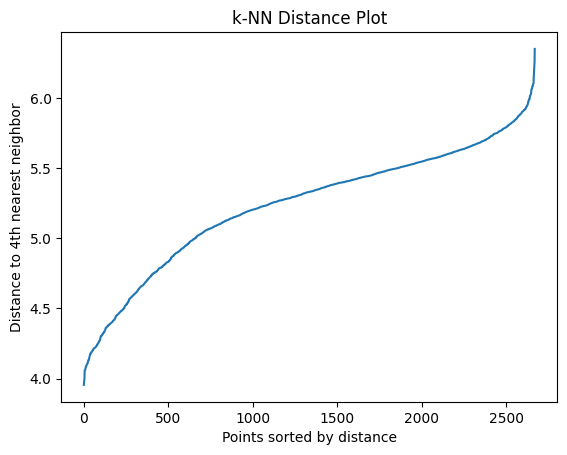

In [194]:
knn_plot(hog_data_n_test)

In [198]:
arr = np.linspace(4.81, 4.9, num=10) # results from 3 minpoints 
experiment_eps("hog n data", arr, hog_truth_n_test, hog_data_n_test)

# chosen minpt is 0.1 of sample size  66
# the chosen eps:  4.81
# The unique labels are:  [-1  0  1]
# the amount of noisy samples are:  1593
# F1 score:  0.028622279390097045


hog n data
chosen minpt is 0.1 of sample size  66
the chosen eps:  4.81
The unique labels are:  [-1  0  1]
the amount of noisy samples are:  1593
F1 score:  0.028622279390097045

chosen minpt is 0.1 of sample size  66
the chosen eps:  4.819999999999999
The unique labels are:  [-1  0  1]
the amount of noisy samples are:  1579
F1 score:  0.028484074801250536

chosen minpt is 0.1 of sample size  66
the chosen eps:  4.83
The unique labels are:  [-1  0  1]
the amount of noisy samples are:  1567
F1 score:  0.028367876758145616

chosen minpt is 0.1 of sample size  66
the chosen eps:  4.84
The unique labels are:  [-1  0  1  2]
the amount of noisy samples are:  1492
F1 score:  0.02828206407923219

chosen minpt is 0.1 of sample size  66
the chosen eps:  4.85
The unique labels are:  [-1  0  1  2]
the amount of noisy samples are:  1477
F1 score:  0.028150796032988083

chosen minpt is 0.1 of sample size  66
the chosen eps:  4.86
The unique labels are:  [-1  0  1  2]
the amount of noisy samples are:

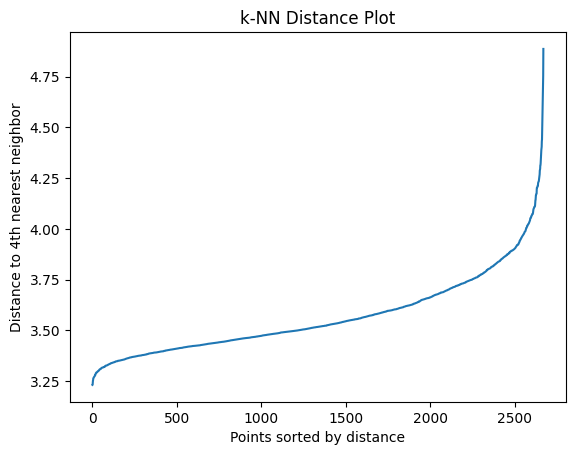

In [199]:
knn_plot(hog_data_test)

In [204]:
arr = np.linspace(3.251, 3.26, num=10)

experiment_eps("hog data", arr, hog_truth_test, hog_data_test)

# chosen minpt is 0.1 of sample size  66
# the chosen eps:  3.259
# The unique labels are:  [-1  0  1]
# the amount of noisy samples are:  2370
# F1 score:  0.09413519100886412


hog data
chosen minpt is 0.1 of sample size  66
the chosen eps:  3.251
The unique labels are:  [-1  0  1]
the amount of noisy samples are:  2460
F1 score:  0.04720156814084771

chosen minpt is 0.1 of sample size  66
the chosen eps:  3.252
The unique labels are:  [-1  0  1]
the amount of noisy samples are:  2456
F1 score:  0.04719719545200297

chosen minpt is 0.1 of sample size  66
the chosen eps:  3.2529999999999997
The unique labels are:  [-1  0  1]
the amount of noisy samples are:  2453
F1 score:  0.04790478332087321

chosen minpt is 0.1 of sample size  66
the chosen eps:  3.254
The unique labels are:  [-1  0  1]
the amount of noisy samples are:  2419
F1 score:  0.0703074923326412

chosen minpt is 0.1 of sample size  66
the chosen eps:  3.255
The unique labels are:  [-1  0  1]
the amount of noisy samples are:  2414
F1 score:  0.07237574395317355

chosen minpt is 0.1 of sample size  66
the chosen eps:  3.256
The unique labels are:  [-1  0  1]
the amount of noisy samples are:  2407
F1 

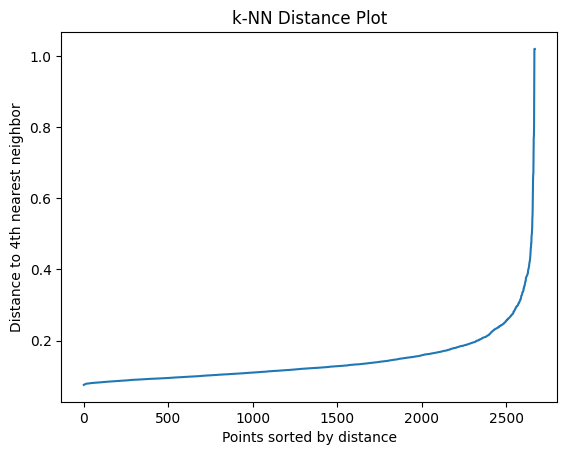

In [205]:
knn_plot(glcm_data_test_n)

In [210]:
arr = np.linspace(0.071, 0.09, num=20)
experiment_eps("glcm n data", arr, glcm_truth_test_n , glcm_data_test_n)

# chosen minpt is 0.1 of sample size  66
# the chosen eps:  0.076
# The unique labels are:  [-1  0  1]
# the amount of noisy samples are:  2514
# F1 score:  0.04726882976564941


glcm n data
chosen minpt is 0.1 of sample size  66
the chosen eps:  0.071
The unique labels are:  [-1]
the amount of noisy samples are:  2669

chosen minpt is 0.1 of sample size  66
the chosen eps:  0.072
The unique labels are:  [-1]
the amount of noisy samples are:  2669

chosen minpt is 0.1 of sample size  66
the chosen eps:  0.073
The unique labels are:  [-1]
the amount of noisy samples are:  2669

chosen minpt is 0.1 of sample size  66
the chosen eps:  0.074
The unique labels are:  [-1]
the amount of noisy samples are:  2669

chosen minpt is 0.1 of sample size  66
the chosen eps:  0.075
The unique labels are:  [-1]
the amount of noisy samples are:  2669

chosen minpt is 0.1 of sample size  66
the chosen eps:  0.076
The unique labels are:  [-1  0  1]
the amount of noisy samples are:  2514
F1 score:  0.04726882976564941

chosen minpt is 0.1 of sample size  66
the chosen eps:  0.077
The unique labels are:  [-1  0]
the amount of noisy samples are:  2447
F1 score:  0.0013356685843214425

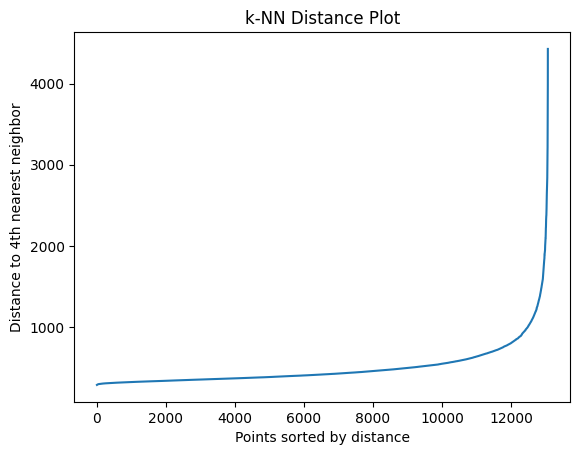

In [211]:
knn_plot(glcm_data_test)

In [223]:
arr = np.linspace(291,295, num=10)
experiment_eps("glcm data", arr, glcm_truth_test , glcm_data_test)

# chosen minpt is 0.1 of sample size  66
# the chosen eps:  294.1111111111111
# The unique labels are:  [-1  0  1]
# the amount of noisy samples are:  1729
# F1 score:  0.1045771853001049


glcm data
chosen minpt is 0.1 of sample size  66
the chosen eps:  291.0
The unique labels are:  [-1  0  1  2]
the amount of noisy samples are:  1820
F1 score:  0.09797499722590436

chosen minpt is 0.1 of sample size  66
the chosen eps:  291.44444444444446
The unique labels are:  [-1  0  1  2]
the amount of noisy samples are:  1819
F1 score:  0.09796617044744206

chosen minpt is 0.1 of sample size  66
the chosen eps:  291.8888888888889
The unique labels are:  [-1  0  1  2]
the amount of noisy samples are:  1808
F1 score:  0.0978962600160331

chosen minpt is 0.1 of sample size  66
the chosen eps:  292.3333333333333
The unique labels are:  [-1  0  1  2  3]
the amount of noisy samples are:  1756
F1 score:  0.10334397362322961

chosen minpt is 0.1 of sample size  66
the chosen eps:  292.77777777777777
The unique labels are:  [-1  0  1  2  3]
the amount of noisy samples are:  1748
F1 score:  0.10328214563687885

chosen minpt is 0.1 of sample size  66
the chosen eps:  293.22222222222223
The u

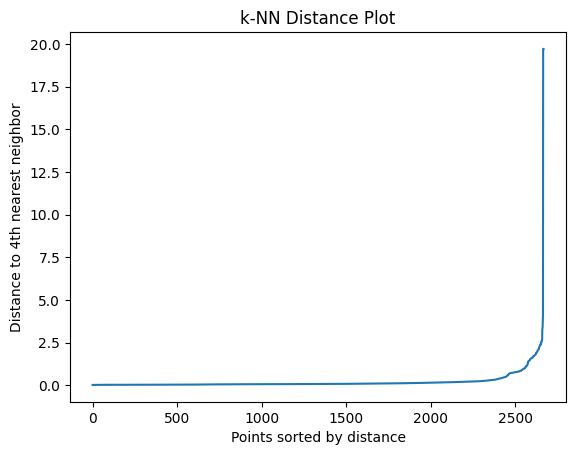

In [228]:
knn_plot(hist_data_n_test)

In [230]:
#arr = np.linspace(201,400, num=200)
arr = np.linspace(0.01,4, num=40)
experiment_eps("hist n data", arr, hist_truth_n_test, hist_data_n_test)

# chosen minpt is 0.1 of sample size  66
# the chosen eps:  1.34
# The unique labels are:  [-1  0  1]
# the amount of noisy samples are:  74
# F1 score:  0.6974513447274793

hist n data
chosen minpt is 0.1 of sample size  66
the chosen eps:  0.01
The unique labels are:  [-1]
the amount of noisy samples are:  2669

chosen minpt is 0.1 of sample size  66
the chosen eps:  0.1123076923076923
The unique labels are:  [-1  0  1]
the amount of noisy samples are:  656
F1 score:  0.638751054389798

chosen minpt is 0.1 of sample size  66
the chosen eps:  0.21461538461538462
The unique labels are:  [-1  0  1  2]
the amount of noisy samples are:  278
F1 score:  0.6762694252178818

chosen minpt is 0.1 of sample size  66
the chosen eps:  0.3169230769230769
The unique labels are:  [-1  0  1  2]
the amount of noisy samples are:  212
F1 score:  0.6809851518278816

chosen minpt is 0.1 of sample size  66
the chosen eps:  0.41923076923076924
The unique labels are:  [-1  0  1  2]
the amount of noisy samples are:  199
F1 score:  0.6830778031679847

chosen minpt is 0.1 of sample size  66
the chosen eps:  0.5215384615384615
The unique labels are:  [-1  0  1  2]
the amount of noisy

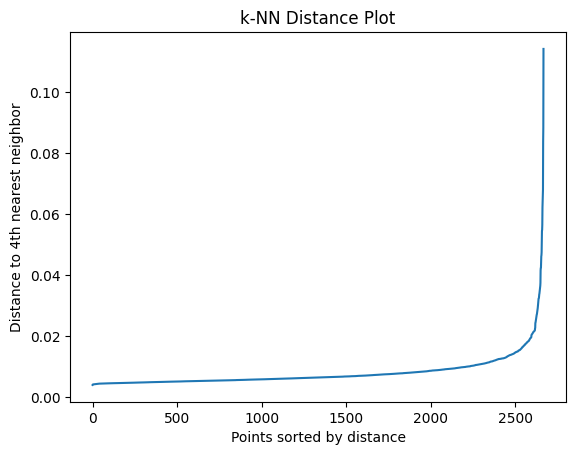

In [233]:
knn_plot(hist_data_test)

In [238]:
arr = np.linspace(0.0041,0.005, num=10)
experiment_eps("hist data", arr, hist_truth_test, hist_data_test)

# chosen minpt is 0.1 of sample size  66
# the chosen eps:  0.004200000000000001
# The unique labels are:  [-1  0  1]
# the amount of noisy samples are:  2295
# F1 score:  0.04244043330528836


hist data
chosen minpt is 0.1 of sample size  66
the chosen eps:  0.0041
The unique labels are:  [-1  0]
the amount of noisy samples are:  2561
F1 score:  0.001124881779251469

chosen minpt is 0.1 of sample size  66
the chosen eps:  0.004200000000000001


The unique labels are:  [-1  0  1]
the amount of noisy samples are:  2295
F1 score:  0.04244043330528836

chosen minpt is 0.1 of sample size  66
the chosen eps:  0.0043
The unique labels are:  [-1  0]
the amount of noisy samples are:  2166
F1 score:  0.0029412669711104235

chosen minpt is 0.1 of sample size  66
the chosen eps:  0.0044
The unique labels are:  [-1  0]
the amount of noisy samples are:  2050
F1 score:  0.0030958081170501237

chosen minpt is 0.1 of sample size  66
the chosen eps:  0.0045000000000000005
The unique labels are:  [-1  0]
the amount of noisy samples are:  1848
F1 score:  0.003825186992794917

chosen minpt is 0.1 of sample size  66
the chosen eps:  0.0046
The unique labels are:  [-1  0]
the amount of noisy samples are:  1713
F1 score:  0.004372637642297182

chosen minpt is 0.1 of sample size  66
the chosen eps:  0.0047
The unique labels are:  [-1  0]
the amount of noisy samples are:  1617
F1 score:  0.004775233435449863

chosen minpt is 0.1 of sample size  66
the

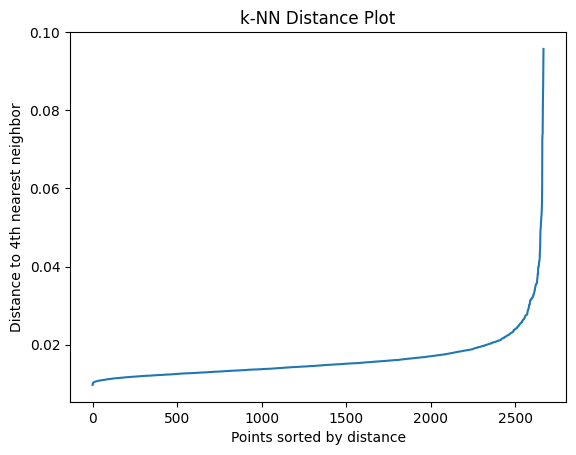

In [239]:
knn_plot(lbp_data_test)

In [245]:
arr = np.linspace(0.002,0.011, num=10)
experiment_eps("lbp data", arr, lbp_truth_test, lbp_data_test)

# chosen minpt is 0.1 of sample size  66
# the chosen eps:  0.01
# The unique labels are:  [-1  0  1]
# the amount of noisy samples are:  2525
# F1 score:  0.05038290304924796

lbp data
chosen minpt is 0.1 of sample size  66
the chosen eps:  0.002
The unique labels are:  [-1]
the amount of noisy samples are:  2669

chosen minpt is 0.1 of sample size  66
the chosen eps:  0.003
The unique labels are:  [-1]
the amount of noisy samples are:  2669

chosen minpt is 0.1 of sample size  66
the chosen eps:  0.004
The unique labels are:  [-1]
the amount of noisy samples are:  2669

chosen minpt is 0.1 of sample size  66
the chosen eps:  0.005
The unique labels are:  [-1]
the amount of noisy samples are:  2669

chosen minpt is 0.1 of sample size  66
the chosen eps:  0.006
The unique labels are:  [-1]
the amount of noisy samples are:  2669

chosen minpt is 0.1 of sample size  66
the chosen eps:  0.007
The unique labels are:  [-1]
the amount of noisy samples are:  2669

chosen minpt is 0.1 of sample size  66
the chosen eps:  0.008
The unique labels are:  [-1]
the amount of noisy samples are:  2669

chosen minpt is 0.1 of sample size  66
the chosen eps:  0.0090000000000000

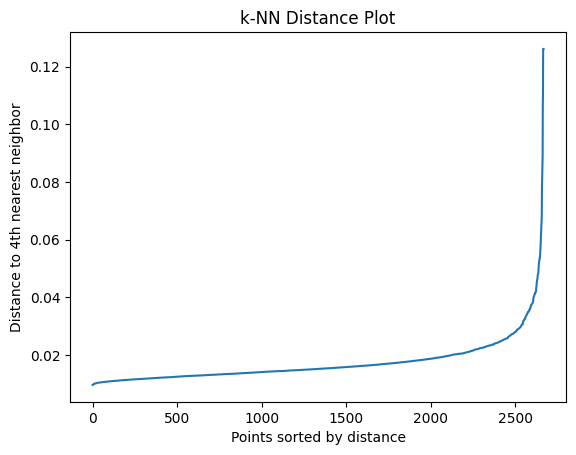

In [246]:
knn_plot(lbp_data_n_test)

In [252]:
arr = np.linspace(0.0096,0.01, num=100)
arr = [0.009701, 0.009702, 0.009703, 0.009704, 0.009705, 0.009706, 0.009707, 0.009708]
experiment_eps("lbp data", arr, lbp_truth_n_test, lbp_data_n_test)

# chosen minpt is 0.1 of sample size  66
# the chosen eps:  0.0097010101010101
# The unique labels are:  [-1  0  1]
# the amount of noisy samples are:  2535
# F1 score:  0.038449183583668375

# chosen minpt is 0.1 of sample size  66
# the chosen eps:  0.00971
# The unique labels are:  [-1  0  1]
# the amount of noisy samples are:  2535
# F1 score:  0.03772670069896626


# chosen minpt is 0.1 of sample size  66
# the chosen eps:  0.00974
# The unique labels are:  [-1  0  1]
# the amount of noisy samples are:  2534
# F1 score:  0.03772232242870149


# chosen minpt is 0.1 of sample size  66
# the chosen eps:  0.009749494949494949
# The unique labels are:  [-1  0  1]
# the amount of noisy samples are:  2533
# F1 score:  0.03844040552829722



# chosen minpt is 0.1 of sample size  66
# the chosen eps:  0.00975
# The unique labels are:  [-1  0  1]
# the amount of noisy samples are:  2518
# F1 score:  0.04914017133210346



lbp data
chosen minpt is 0.1 of sample size  66
the chosen eps:  0.0096
The unique labels are:  [-1]
the amount of noisy samples are:  2669

chosen minpt is 0.1 of sample size  66
the chosen eps:  0.009604040404040403
The unique labels are:  [-1]
the amount of noisy samples are:  2669

chosen minpt is 0.1 of sample size  66
the chosen eps:  0.009608080808080807
The unique labels are:  [-1]
the amount of noisy samples are:  2669

chosen minpt is 0.1 of sample size  66
the chosen eps:  0.00961212121212121
The unique labels are:  [-1]
the amount of noisy samples are:  2669

chosen minpt is 0.1 of sample size  66
the chosen eps:  0.009616161616161615
The unique labels are:  [-1]
the amount of noisy samples are:  2669

chosen minpt is 0.1 of sample size  66
the chosen eps:  0.00962020202020202
The unique labels are:  [-1  0]
the amount of noisy samples are:  2603
F1 score:  0.0006228565350586779

chosen minpt is 0.1 of sample size  66
the chosen eps:  0.009624242424242424
The unique labels 

In [254]:
p_r_f1 ={}

In [260]:
# official min points 
record_results(4.81, hog_truth_n , hog_data_n,  p_r_f1,   "hog_n" )
record_results(3.259, hog_truth , hog_data,  p_r_f1,   "hog" )

record_results(0.076, glcm_truth_n , glcm_data_n,  p_r_f1,   "glcm_n" )
record_results(294, glcm_truth , glcm_data,  p_r_f1,   "glcm" )

record_results(1.34, hist_truth_n , hist_data_n,  p_r_f1,   "hist_n" )
record_results(0.042, hist_truth , hist_data,  p_r_f1,   "hist" )


record_results(0.01, lbp_truth , lbp_data,  p_r_f1,   "lbp" )
record_results( 0.00975, lbp_truth_n , lbp_data_n,  p_r_f1,   "lbp_n" )

chosen minpt is 0.1 of sample size  326
the chosen eps:  4.81
The unique labels are:  [-1  0  1]
the amount of noisy samples are:  6148
hog_n
f1 :  0.06051939559855427 
precision:  0.41348380410793906 
recall:  0.05854442488712023
chosen minpt is 0.1 of sample size  326
the chosen eps:  3.259
The unique labels are:  [-1  0]
the amount of noisy samples are:  8821
hog
max precision:  0.01926030657929139
max recall:  0.01926030657929139
max f1 :  0.03337667260603869
f1 :  0.0009055353604235524 
precision:  0.0006575048318854949 
recall:  0.00145404453968011
chosen minpt is 0.1 of sample size  326
the chosen eps:  0.076


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


The unique labels are:  [-1]
the amount of noisy samples are:  13067
glcm_n
f1 :  0.0 
precision:  0.0 
recall:  0.0
chosen minpt is 0.1 of sample size  326
the chosen eps:  294


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


The unique labels are:  [-1  0  1  2]
the amount of noisy samples are:  11227
glcm
max recall:  0.877355909445252
max f1 :  0.39071973278948446
f1 :  0.15620473484885586 
precision:  0.877355909445252 
recall:  0.08823754496058774
chosen minpt is 0.1 of sample size  326
the chosen eps:  1.34
The unique labels are:  [-1  0  1  2]
the amount of noisy samples are:  42
hist_n
f1 :  0.12159110592181821 
precision:  0.8130221075910423 
recall:  0.14150149230886966
chosen minpt is 0.1 of sample size  326
the chosen eps:  0.042
The unique labels are:  [-1  0]
the amount of noisy samples are:  13
hist
f1 :  0.03760217871687778 
precision:  0.02156637904498728 
recall:  0.14662891252774163
chosen minpt is 0.1 of sample size  326
the chosen eps:  0.01


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


The unique labels are:  [-1]
the amount of noisy samples are:  13067
lbp
f1 :  0.0 
precision:  0.0 
recall:  0.0
chosen minpt is 0.1 of sample size  326
the chosen eps:  0.00975


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


The unique labels are:  [-1  0]
the amount of noisy samples are:  12734
lbp_n
f1 :  0.0024782649943948616 
precision:  0.00838368022878622 
recall:  0.00145404453968011


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [257]:
# results from minpt at 3 
record_results(3.655, hog_truth , hog_data,  p_r_f1,   "hog" )
record_results(3.78, hog_truth_n , hog_data_n,  p_r_f1,   "hog_n" )
record_results(613.5, glcm_truth , glcm_data,  p_r_f1,   "glcm" )
record_results(0.05, glcm_truth_n , glcm_data_n,  p_r_f1,   "glcm_n" )
record_results(374, hist_truth_n , hist_data_n,  p_r_f1,   "hist_n" )
record_results(373, hist_truth , hist_data,  p_r_f1,   "hist" )
record_results(0.01789, lbp_truth , lbp_data,  p_r_f1,   "lbp" )

# lbp
# f1 :  0.03706204445867489 
# precision:  0.5898159177581467 
# recall:  0.14234330756868446

#record_results( , lbp_truth_n , lbp_data_n,  p_r_f1,   "lbp_n" )

chosen minpt is 0.1 of sample size  326
the chosen eps:  3.655
The unique labels are:  [-1  0]
the amount of noisy samples are:  609
hog
f1 :  0.03337667260603869 
precision:  0.01926030657929139 
recall:  0.12497130175250631
chosen minpt is 0.1 of sample size  326
the chosen eps:  3.78


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


KeyboardInterrupt: 

chosen minpt is 0.1 of sample size  326
the chosen eps:  3
The unique labels are:  [-1  0  1]
the amount of noisy samples are:  19
hist_n
f1 :  0.10121822653544152 
precision:  0.7894645715985369 
recall:  0.17624550394122598


In [258]:
record_results(306, glcm_truth , glcm_data,  p_r_f1,   "glcm" )

chosen minpt is 0.1 of sample size  326
the chosen eps:  306
The unique labels are:  [-1  0  1]
the amount of noisy samples are:  8679
glcm
max precision:  0.877355909445252
f1 :  0.39071973278948446 
precision:  0.834543283997745 
recall:  0.2583607561031606


In [ ]:
# appendix section 
record_results(306, glcm_truth , glcm_data,  p_r_f1,   "glcm" )
record_results(3, hist_truth_n , hist_data_n,  p_r_f1,   "hist_n" )


record_results(4.81, hog_truth_n , hog_data_n,  p_r_f1,   "hog_n" )
record_results(3.259, hog_truth , hog_data,  p_r_f1,   "hog" )

record_results(0.076, glcm_truth_n , glcm_data_n,  p_r_f1,   "glcm_n" )


record_results(373, hist_truth , hist_data,  p_r_f1,   "hist" )
record_results(0.01789, lbp_truth , lbp_data,  p_r_f1,   "lbp" )
record_results( 0, lbp_truth_n , lbp_data_n,  p_r_f1,   "lbp_n" )